In [1]:
import os
import sys
import inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
folder = "env"
sourcedir = currentdir.split(folder)[0]
sys.path.insert(0, sourcedir)
# from env.equation.equation import Equation
print(sourcedir)


/home/valdecar/Documents/projects/project/parser/


##### Введение:

In [2]:
print(sys.path[0])
from env.equation.equation import Equation

/home/valdecar/Documents/projects/project/parser/


Некоторые поддерживаемые типы уравнений приведены ниже (Чтобы запустеть все доступные тесты нужно выполнить из папки equation: 
`python3 tests.py`):

In [3]:
eq_all = Equation("U'=(V(t-3.1)*U(t-3.1)+V(t-1.1)*U(t-3.1)+U(t-1.1))^3"
              + "+cos(U-c*D[U,{x,2}])")
eq_delay = Equation("U'=V(t-3.1)*U(t-3.1)+V(t-1.1)*U(t-3.1)")
eq_pow = Equation("U'=(V(t-3.1)+U)^3")
eq_diff = Equation("U'= U-c*D[U,{x,2}]")
eq_func = Equation("V + cos(x-c*D[U,{x,2}])")

eqs = [eq_all, eq_delay, eq_pow, eq_diff, eq_func]
for eq in eqs:
    eq.parser.parse()

Чтобы произвести преобразование к cpp необходимо задать некоторые параметры. По умолчанию можно задать их используя set_default метод.

In [4]:
for eq in eqs:
    eq.replacer.cpp.editor.set_default()

Чтобы узнать стандартные параметры проще всего глянуть ее исходник. Для этого в сдед ячейке использована jupyter команда `??e_all.set_default`.
Более точное описание см. ниже.

In [5]:
# uncomment next line to see source:
# ??eq_all.set_default

После того, как параметры заданы можно уже генерировать cpp строку:

In [6]:
for eq in eqs:
    print("\noriginal:")
    eq.show_original()
    eq.replacer.cpp.make_cpp()
    print("\ncpp:")
    eq.replacer.cpp.show_cpp()


original:
(U')=(V(t-3.1)*U(t-3.1)+V(t-1.1)*U(t-3.1)+U(t-1.1))^3+cos(U-c*D[U,{x,2}])

cpp:
source[delay][idx + 0]=pow(source[delay][idx + 1]*source[delay][idx + 0]+source[delay][idx + 1]*source[delay][idx + 0]+source[delay][idx + 0],3)+cos(source[delay][idx + 0]-params[2]*(DXM2 * (source[delay][idx + 1 * Block0StrideX * Block0CELLSIZE + 0] - 2.0 * source[delay][idx + 0 * Block0StrideX * Block0CELLSIZE + 0] + source[delay][idx-1 * Block0StrideX * Block0CELLSIZE + 0])))

original:
(U')=V(t-3.1)*U(t-3.1)+V(t-1.1)*U(t-3.1)

cpp:
source[delay][idx + 0]=source[delay][idx + 1]*source[delay][idx + 0]+source[delay][idx + 1]*source[delay][idx + 0]

original:
(U')=(V(t-3.1)+U)^3

cpp:
source[delay][idx + 0]=pow(source[delay][idx + 1]+source[delay][idx + 0],3)

original:
(U')=U-c*D[U,{x,2}]

cpp:
source[delay][idx + 0]=source[delay][idx + 0]-params[2]*(DXM2 * (source[delay][idx + 1 * Block0StrideX * Block0CELLSIZE + 0] - 2.0 * source[delay][idx + 0 * Block0StrideX * Block0CELLSIZE + 0] + source[de

Этот результат можно получить в виде строки:

In [7]:
eq_diff.tree.flatten('cpp')

'source[delay][idx + 0]=source[delay][idx + 0]-params[2]*(DXM2 * (source[delay][idx + 1 * Block0StrideX * Block0CELLSIZE + 0] - 2.0 * source[delay][idx + 0 * Block0StrideX * Block0CELLSIZE + 0] + source[delay][idx-1 * Block0StrideX * Block0CELLSIZE + 0]))'

##### Описание cpp параметров

Вместо функции set_default можно установиь параметры явно:

In [8]:
sent = "U-c*D[U,{x,2}]"
eq_diff = Equation(sent)
eq_diff.parser.parse()

eq_diff.replacer.cpp.editor.set_default()
eq_diff.replacer.cpp.editor.set_dim(dim=2)
eq_diff.replacer.cpp.editor.set_blockNumber(blockNumber=0)

eq_diff.replacer.cpp.editor.set_vars_indexes(vars_to_indexes=[('U', 0), ('V', 1)])

coeffs_to_indexes = [('a', 0), ('b', 1), ('c', 2), ('r', 3)]
eq_diff.replacer.cpp.editor.set_coeffs_indexes(coeffs_to_indexes=coeffs_to_indexes)

eq_diff.replacer.cpp.editor.set_diff_type(diffType='pure',
                                          diffMethod='borders',
                                          side=0, func="sin(idxX)")
eq_diff.replacer.cpp.make_cpp()
eq_diff.replacer.cpp.show_cpp()

source[delay][idx + 0]-params[2]*(2.0 * DXM2 * (source[delay][idx + Block0StrideX * Block0CELLSIZE + 0] - source[delay][idx + 0] - (sin(idxX)) * DX))


Только использование последнего метода отличает от умолчания. Если теперь поменять diffMethod, то результат измениться:

In [9]:
eq_diff.replacer.cpp.editor.set_diff_type(diffType='pure',
                                          diffMethod='common')
eq_diff.replacer.cpp.make_cpp()
eq_diff.replacer.cpp.show_cpp()

source[delay][idx + 0]-params[2]*(DXM2 * (source[delay][idx + 1 * Block0StrideX * Block0CELLSIZE + 0] - 2.0 * source[delay][idx + 0 * Block0StrideX * Block0CELLSIZE + 0] + source[delay][idx-1 * Block0StrideX * Block0CELLSIZE + 0]))


##### Использование sympy

Для некоторых pde уравнений можно использовать sympy.pde методы. Для конвертации wolfram to sympy используется функция e.replacer.sympy.make_sympy и e.slambda.sympy.lambdify. Первая просто генерирует читабельную строку, вторая генерирует sympy объект.

In [17]:
import sympy

e = Equation("U=U-a*(D[U,{x,1}])+sin(x)")
e.parser.parse()

e.args_editor.get_vars()
    
x, U = sympy.symbols('x U')

# work also for print:
# c = sympy.Matrix([[0, -1], [1, 0]])
e.args_editor.subs(x=x, U=U, a=1)

e.slambda.sympy.lambdify_sem()
out = e.slambda.sympy.lambdify()
print("\nlambdify:")
print(out())

e.replacer.sympy.make_sympy()
print("\nmake_sympy:")
e.replacer.sympy.show_sympy()
# e.slambda.sympy.show_sympy_lambda()

diff(U(t, x),x, 1)

lambdify:
Eq(U, U + sin(x) - Derivative(U(t, x), x))

make_sympy:
U(t)=U(t)-a*(diff(U,x, 1))+sympy.sin(x)


Вывод make_sympy является просто строкой, вывод lambdify является sympy объектом, к которому можно применить ряд методов sympy:

После этого можно провести некоторый предварительный анализ pde:

In [18]:
e.cas.classify_pde()

('1st_linear_constant_coeff', '1st_linear_constant_coeff_Integral')

In [20]:
e.cas.pdsolve().rhs

t - cos(x)

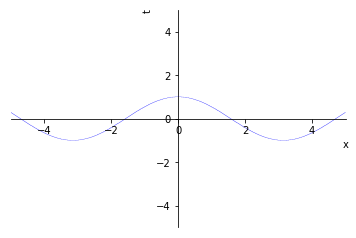

In [22]:
# slow:
e.cas.plot_pde()
# sympy.plotting.plot_implicit(e.eq_sympy_solved.rhs)

Пока это работает только для простых задач, но со временем их число может возрасти.